In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import copy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import statistics
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import numpy as np

In [55]:
class DataAnalyzer:
    def __init__(self):
        file_path = 'Regression.Life.Expectancy.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.dataset = self.dataset.drop(self.dataset.columns[0], axis=1)
        self.original_dataset = self.dataset
        self.fill_nan_vals()
        # print(self.dataset.shape[1])
        self.dataset = self.dataset.dropna(axis=1)
        # print(self.dataset.shape[1])
        self.convert_and_encode()
        self.remove_outliers()
        # self.dataset = self.dataset.drop(columns=['lights'])
        clmns_to_drop = [" HIV/AIDS", "infant deaths", "percentage expenditure", "Measles ", "under-five deaths ", "GDP", "Population"]
        self.dataset = self.dataset.drop(columns=clmns_to_drop)
        # for to_drop in clmns_to_drop:

        # self.normalize_df_by_max()

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def convert_and_encode(self):
        label_encoder = LabelEncoder()
        columns_to_exclude = ["Status", "Year"]
        for column in self.dataset.columns:
            if column not in columns_to_exclude:
                self.dataset.loc[:, column] = self.dataset[column].astype(float)
            else:
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset.loc[:, column] = encoded_values
                if column == "Year":
                    self.dataset.loc[:, column] = self.dataset[column].astype(float)



    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=4, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['Life expectancy '] < 42))]
        self.dataset = self.dataset[~((self.dataset['Adult Mortality'] > 500))]
        self.dataset = self.dataset[~((self.dataset['Hepatitis B'] < 50))]
        self.dataset = self.dataset[~((self.dataset['Polio'] < 40))]
        self.dataset = self.dataset[~((self.dataset['Total expenditure'] > 15))]
        self.dataset = self.dataset[~((self.dataset['Diphtheria '] < 40))]
        self.dataset = self.dataset[~((self.dataset[' thinness  1-19 years'] > 20))]
        return self.dataset

    def normalize_df_by_max(self):
        columns_to_exclude=[]
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns:
            if column not in columns_to_exclude:
                max_abs_value = abs(self.dataset[column]).max()
                normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return self.dataset

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test_final = sc.transform(self.X_test_final)
        if self.X_cv is not None:
            self.X_cv = sc.fit_transform(self.X_cv)
        return(self.X_train, self.X_test_final, self.X_cv)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self, dataset = None):
        if dataset is None:
            corr_matrix = self.dataset.corr()
        else:
            corr_matrix = dataset.corr()
        plt.figure(figsize=(20, 20))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def perform_filter_methods(self):
        data = copy.deepcopy(self.dataset)
        X = copy.deepcopy(data).drop(columns=['Life expectancy '])  # Features
        print("total features = ", len(X.columns))
        y = copy.deepcopy(data['Life expectancy ']).astype(float) 
        # Calculate Mutual Information scores
        mi_scores = mutual_info_regression(X, y)
        # Select features with MI score > 0.5
        selected_features = X.columns[mi_scores > 0.05]
        print("selected features with high mutual information with the target = ", len(selected_features))
        # Calculate correlation matrix
        corr_matrix = X[selected_features].corr().abs()
        copy_ds = copy.deepcopy(data[selected_features])
        # Remove one of two highly correlated features
        to_drop = set()
        dropped_columns = {}
        for i in range(len(corr_matrix.columns)):
            if i not in dropped_columns:
                for j in range(len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.8 and i!=j and j not in dropped_columns and i not in dropped_columns and i!=j:
                        
                        colname_i = corr_matrix.columns[i]
                        colname_j = corr_matrix.columns[j]
                        # Calculate the Mutual Information score of each feature with the target variable
                        mi_i = mutual_info_regression(X[colname_i].values.reshape(-1, 1), y)[0]
                        mi_j = mutual_info_regression(X[colname_j].values.reshape(-1, 1), y)[0]
                        # Keep the feature with higher Mutual Information score
                        if mi_i > mi_j:
                            to_drop.add(colname_j)
                            dropped_columns[j] = colname_j
                        else:
                            to_drop.add(colname_i)
                            dropped_columns[i] = colname_i
        final_selected_features = selected_features.drop(to_drop)
        print("final selected features after removing one of two correlated features = ", len(final_selected_features))
        self.dataset = self.dataset[final_selected_features]
        self.dataset["Life expectancy "] = data["Life expectancy "]
        self.show_heat_map()
        return self.dataset
    
    def perform_wrapper_method(self):
        feature_scores = []
        feature_scores_dict = {}
        total_num_of_columns = len(self.X.columns)
        for i in range(1,total_num_of_columns+1):
            newAnlyzr = DataAnalyzer()
            newAnlyzr.get_x_and_Y()
            (best_avg_score, scores) = newAnlyzr.perform_kfold_cv(num_of_columns=i)
            if best_avg_score <= 0:
                continue
            mean_score = newAnlyzr.get_accuracy()

            feature_scores.append((i, mean_score))
            feature_scores_dict[i] = mean_score
        self.feature_scores = feature_scores
        additional_feature_penalty = -0.05
        score_weight = 0.95
        adjusted_scores = []
        best_num_of_features = 1
        best_adjusted_score = 0
        for (j, mn_score) in feature_scores:
            adjusted_score = mn_score*score_weight + j*additional_feature_penalty/total_num_of_columns
            adjusted_scores.append((j, adjusted_score))
            if adjusted_score > best_adjusted_score:
                best_adjusted_score = adjusted_score
                best_num_of_features = j
        best_score = feature_scores_dict[best_num_of_features]

        self.get_x_and_Y()
        (best_avg_score, scores) = self.perform_kfold_cv(num_of_columns=best_num_of_features)
        mean_score = self.get_accuracy()
        
        feature_scores.append((i, mean_score))
        feature_scores_dict[i] = mean_score

        return {
            "best_num_of_features": best_num_of_features,
            "best_score": best_score
        }
    
    def plot_wrapper_scores(self):
        x_values, y_values = zip(*self.feature_scores)
        # Create a Plotly trace
        trace = go.Scatter(x=x_values, y=y_values, mode='lines+markers')

        # Create a Plotly layout
        layout = go.Layout(
            title='Wrapper Method Feature Scores',
            xaxis=dict(title='Number of Features'),
            yaxis=dict(title='Accuracy')
        )

        # Create a Plotly figure
        fig = go.Figure(data=[trace], layout=layout)

        # Display the plot
        fig.show()

    def perform_pca(self, n_components=None):
        # Standardize the data
        scaler = StandardScaler()
        data = self.X
        standardized_data = scaler.fit_transform(data)

        # Create PCA object
        pca = PCA(n_components=n_components)

        # Fit and transform the data
        pca_data = pca.fit_transform(standardized_data)

        # Create a DataFrame for the PCA results
        pca_columns = [f"PC{i+1}" for i in range(pca_data.shape[1])]
        pca_df = pd.DataFrame(data=pca_data, columns=pca_columns)

        # Concatenate with original dataset
        self.X = pca_df

    def plot_variations(self):
        min_max_scaler = preprocessing.MinMaxScaler()
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['Life expectancy ']
        # x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    
    def get_x_and_Y(self):
        self.X = self.dataset.drop('Life expectancy ', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['Life expectancy ']
        return (self.X, self.y)
    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)
        self.y_train = self.y_train.astype(float)
        y_temp =  y_temp.astype(float)

        # Second split to further split the temporary test set into the second test set
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
        self.y_cv = self.y_cv.astype(float)
        self.y_test_final = self.y_test_final.astype(float)

    def perform_manual_splitting_without_cv(self):
        # First split to get training set and first test set
        self.X_train, self.X_test_final, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        self.y_train = y_train.astype(float)
        self.y_test_final = y_temp.astype(float)

    def perform_knn_without_cv(self):
        self.classifier = KNeighborsRegressor(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_test_final)
        mse = mean_squared_error(self.y_test_final,y_pred1)  # Calculate MSE
        target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
        accuracy_percentage = (1 - (mse / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage

        self.mse =mse
        self.mae = mean_absolute_error(self.y_test_final, y_pred1)
        self.rmse = np.sqrt(mse)
        self.r2_score = r2_score(self.y_test_final, y_pred1)
        return self.ac_final
        

    def perform_knn(self):
        self.classifier = KNeighborsRegressor(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = mean_squared_error(self.y_cv,y_pred1)
        return self.ac_cv

    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        # self.ac_final = mean_squared_error(self.y_test_final,y_pred_final)
        mse = mean_squared_error(self.y_test_final,y_pred_final)  # Calculate mse
        target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
        accuracy_percentage = (1 - (mse / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage

        self.mse =mse
        self.mae = mean_absolute_error(self.y_test_final, y_pred_final)
        self.rmse = np.sqrt(mse)
        self.r2_score = r2_score(self.y_test_final, y_pred_final)
        return self.ac_final

    
    def perform_kfold_cv(self, num_of_columns = None):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if num_of_columns:
            X_train = copy.deepcopy(X_train.iloc[:, :num_of_columns])
            X_test_final = copy.deepcopy(X_test_final.iloc[:, :num_of_columns])
        self.X_train = X_train
        self.y_train = y_train.astype(float)
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final.astype(float)
        classifier = KNeighborsRegressor(n_neighbors = 40, metric = 'minkowski', p = 2.7)

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_score = 0
        best_rmse = 100

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index].astype(float), y_train.iloc[val_index].astype(float)

            # Train the model on the training fold
            classifier.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the validation fold
            y_val_pred = classifier.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_val_pred)
            target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
            accuracy_percentage = (1 - (rmse / target_range)) * 100  # Calculate accuracy as a percentage

            # Update the best model if the current model has a better average performance
            if accuracy_percentage > best_score:
                best_score = accuracy_percentage
                best_model = classifier
                best_rmse = rmse
            scores.append(accuracy_percentage)
        
        self.classifier = best_model
        return(best_score, scores)

class Master:
    def __init__(self):
        self.results = {}
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_without_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_without_cv()
        rslts = anlyzr.perform_knn_without_cv()
        anlyzr.y_test_final
        self.results["run without cv"] = rslts
        self.results["regressors without_cv"] = {
            "without_cv_mse": anlyzr.mse,
            "without_cv_mae": anlyzr.mae,
            "without_cv_rmse": anlyzr.rmse,
            "without_cv_r2_score": anlyzr.r2_score,
        }

    def run_with_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["run with cv"] = anlyzr.get_accuracy()
        self.results["regressors_with_cv"] = {
            "with_cv_mse": anlyzr.mse,
            "with_cv_mae": anlyzr.mae,
            "with_cv_rmse": anlyzr.rmse,
            "with_cv_r2_score": anlyzr.r2_score,
        }

    def run_with_kfold(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        (best_score, scores, best_rmse) = anlyzr.perform_kfold_cv()
        self.results["after_k_fold_run"] = {
            "best kfold cv score": best_score,
            "best_rmse": best_rmse,
            "scores": scores,
            "final kfold score on test dataset": anlyzr.get_accuracy(),
            "kfold_mse": anlyzr.mse,
            "kfold_mae": anlyzr.mae,
            "kfold_rmse": anlyzr.rmse,
            "kfold_r2_score": anlyzr.r2_score,
        }

    def run_with_filter(self):
        # Implement feature selection using filter method (e.g., correlation)
        anlyzr = DataAnalyzer()
        anlyzr.perform_filter_methods()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["with_filter_method"] = anlyzr.get_accuracy()
        self.results["regressors"] = {
            "mse": anlyzr.mse,
            "mae": anlyzr.mae,
            "rmse": anlyzr.rmse,
            "r2_score": anlyzr.r2_score,
        }

    def run_with_wrapper(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        self.results = anlyzr.perform_wrapper_method()
        self.results["regressors"] = {
            "mse": anlyzr.mse,
            "mae": anlyzr.mae,
            "rmse": anlyzr.rmse,
            "r2_score": anlyzr.r2_score,
        }
        anlyzr.plot_wrapper_scores()

    def run_with_pca(self):
        # Implement feature selection using PCA
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_pca(n_components=2)
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["with_pca"] = anlyzr.get_accuracy()
        self.results["regressors"] = {
            "mse": anlyzr.mse,
            "mae": anlyzr.mae,
            "rmse": anlyzr.rmse,
            "r2_score": anlyzr.r2_score,
        }

    def run_with_ols(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()

        anlyzr.X_train = anlyzr.X_train.astype(float)
        anlyzr.y_train = anlyzr.y_train.astype(float)
        #add constant to predictor variables
        x = sm.add_constant(anlyzr.X_train)

        #fit linear regression model
        model = sm.OLS(anlyzr.y_train, anlyzr.X_train).fit()
        print(model.summary())
        y_cv_pred = model.predict(anlyzr.X_cv)

        mse_cv = mean_squared_error(anlyzr.y_cv, y_cv_pred)
        r2 = r2_score(anlyzr.y_cv, y_cv_pred)

        target_range = np.max(anlyzr.y) - np.min(anlyzr.y)  # Calculate the range of the target variable
        accuracy_percentage_cv = (1 - (mse_cv / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage_cv

        # 
        y_test_pred = model.predict(anlyzr.X_test_final)

        mae_ols = mean_absolute_error(anlyzr.y_test_final, y_test_pred)
        mse_test = mean_squared_error(anlyzr.y_test_final, y_test_pred)
        rmse_ols = np.sqrt(mse_test)
        r2 = r2_score(anlyzr.y_test_final, y_test_pred)

        accuracy_percentage_test = (1 - (mse_test / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage_test

        aic = model.aic
        bic = model.bic
        
        # Get p-values
        p_values = model.pvalues
        
        # Store results
        self.results["run_with_ols_cv"] = accuracy_percentage_cv
        self.results["run_with_ols_test"] = accuracy_percentage_test
        self.results["aic"] = aic
        self.results["bic"] = bic
        self.results["p_values"] = p_values
        self.results["mae"] = mae_ols
        self.results["mse"] = mse_test
        self.results["rmse"] = rmse_ols
        self.results["r2_score"] = r2
    
    def run_cv_problem(self):
        self.run_without_cv()
        self.run_with_cv()
        self.run_with_kfold()
        return self.results


In [49]:
ols_mstr = Master()
ols_mstr.run_with_ols()
ols_mstr.organize_results()

                                 OLS Regression Results                                
Dep. Variable:       Life expectancy    R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.541e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):                        0.00
Time:                        22:44:34   Log-Likelihood:                         -4553.4
No. Observations:                1423   AIC:                                      9133.
Df Residuals:                    1410   BIC:                                      9201.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

,method,result
0,run_with_ols_cv,23.968889
1,run_with_ols_test,27.576556
2,aic,9132.794816
3,bic,9201.18161
4,p_values,Year 1.683020e-0...
5,mae,4.436221
6,mse,33.821748
7,rmse,5.815647
8,r2_score,0.485761


In [50]:
cv_mstr = Master()
cv_mstr.run_cv_problem()
cv_mstr.organize_results()

run without cv 81.57199211089824
regressors without_cv {'without_cv_mse': 8.605879684210525, 'without_cv_mae': 1.904736842105263, 'without_cv_rmse': 2.9335779662743797, 'without_cv_r2_score': 0.8630332840039594}
run with cv 76.98870460948946
regressors_with_cv {'with_cv_mse': 10.746274947368423, 'with_cv_mae': 1.9698105263157892, 'with_cv_rmse': 3.2781511477307483, 'with_cv_r2_score': 0.8366093060471694}
after_k_fold_run {'best kfold cv score': 79.83536379263586, 'best_rmse': 9.416885108839052, 'scores': [77.08015739462414, 69.42516070522935, 75.03830968950749, 58.88294568853005, 79.83536379263586], 'final kfold score on test dataset': 76.89653620534204, 'kfold_mse': 10.789317592105263, 'kfold_mae': 2.1637842105263165, 'kfold_rmse': 3.2847096663335806, 'kfold_r2_score': 0.8282828191125782}


,method,result
0,run without cv,81.571992
1,without_cv_mse,8.60588
2,without_cv_mae,1.904737
3,without_cv_rmse,2.933578
4,without_cv_r2_score,0.863033
5,run with cv,76.988705
6,with_cv_mse,10.746275
7,with_cv_mae,1.969811
8,with_cv_rmse,3.278151
9,with_cv_r2_score,0.836609


total features =  13
selected features with high mutual information with the target =  13
final selected features after removing one of two correlated features =  11


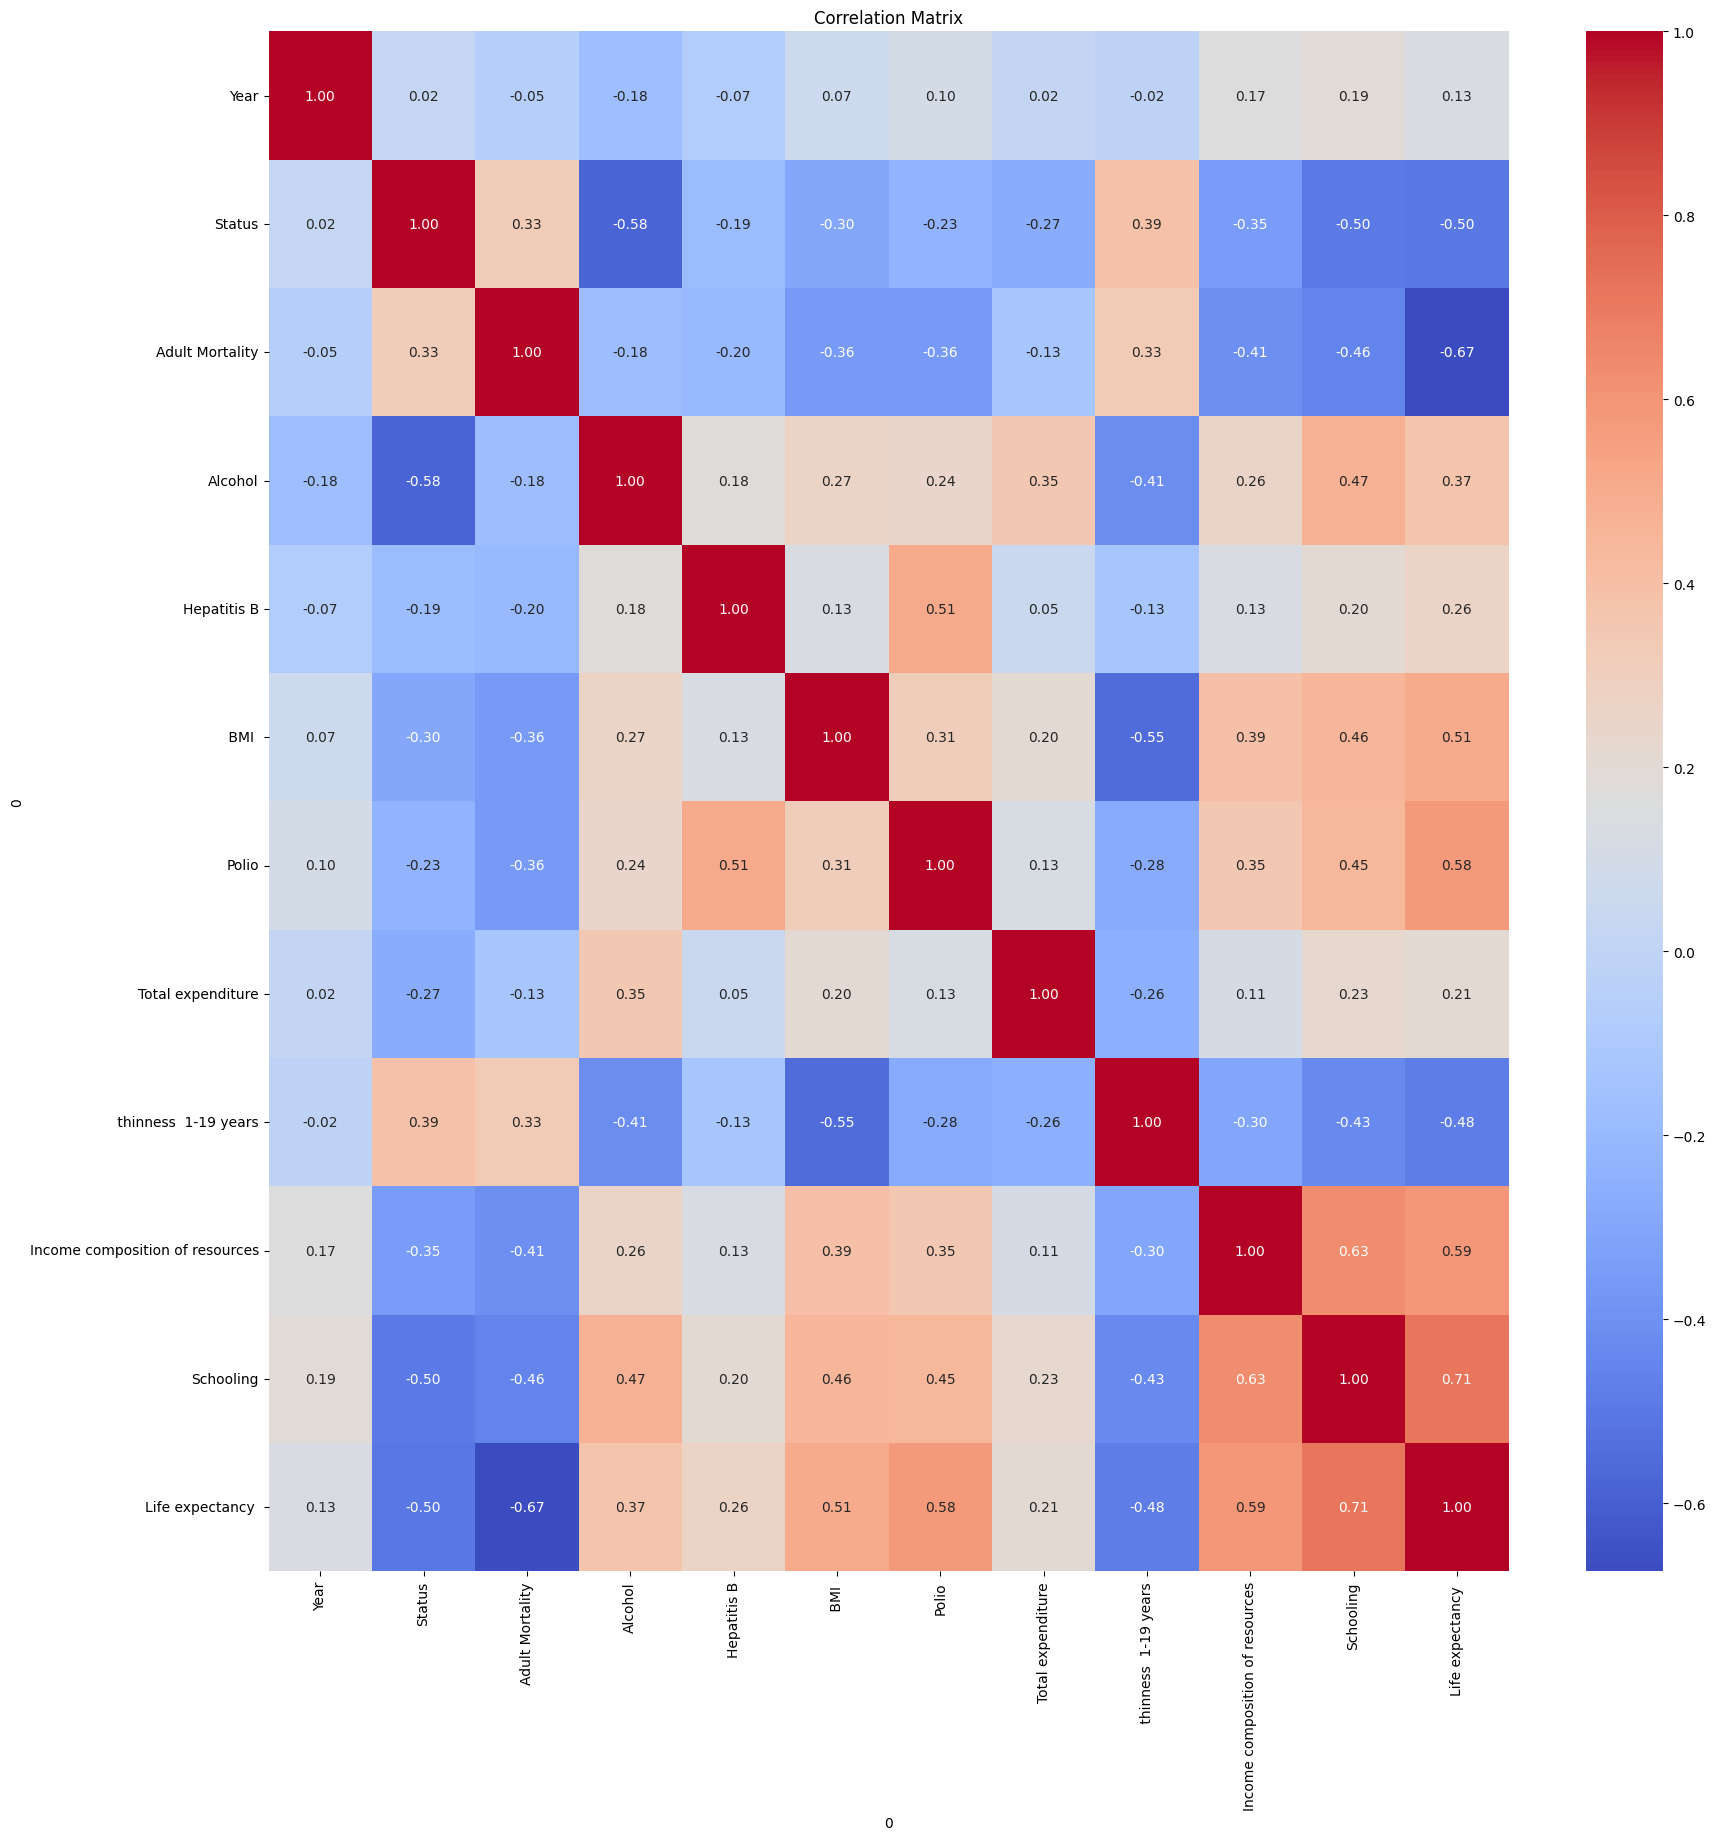

with_filter_method 73.98656418347798
regressors {'mse': 12.148274526315788, 'mae': 2.0106947368421046, 'rmse': 3.4854374942488624, 'r2_score': 0.8152927395859807}


,method,result
0,with_filter_method,73.986564
1,mse,12.148275
2,mae,2.010695
3,rmse,3.485437
4,r2_score,0.815293


In [51]:
filter_mstr = Master()
filter_mstr.run_with_filter()
filter_mstr.organize_results()

In [56]:
wrapper_mstr = Master()
wrapper_mstr.run_with_wrapper()
wrapper_mstr.organize_results()

16.855017868421054
15.186601750000003
15.631391907894741
13.10659452631579
11.667453039473683
11.645254881578946
11.061654434210526
10.871592644736841
10.85386560526316
10.85386560526316
10.789317592105263


AttributeError: 'DataAnalyzer' object has no attribute 'mse'

In [38]:
pca_mstr = Master()
pca_mstr.run_with_pca()
pca_mstr.organize_results()

with_pca 62.27139084864195


,method,result
0,with_pca,62.271391


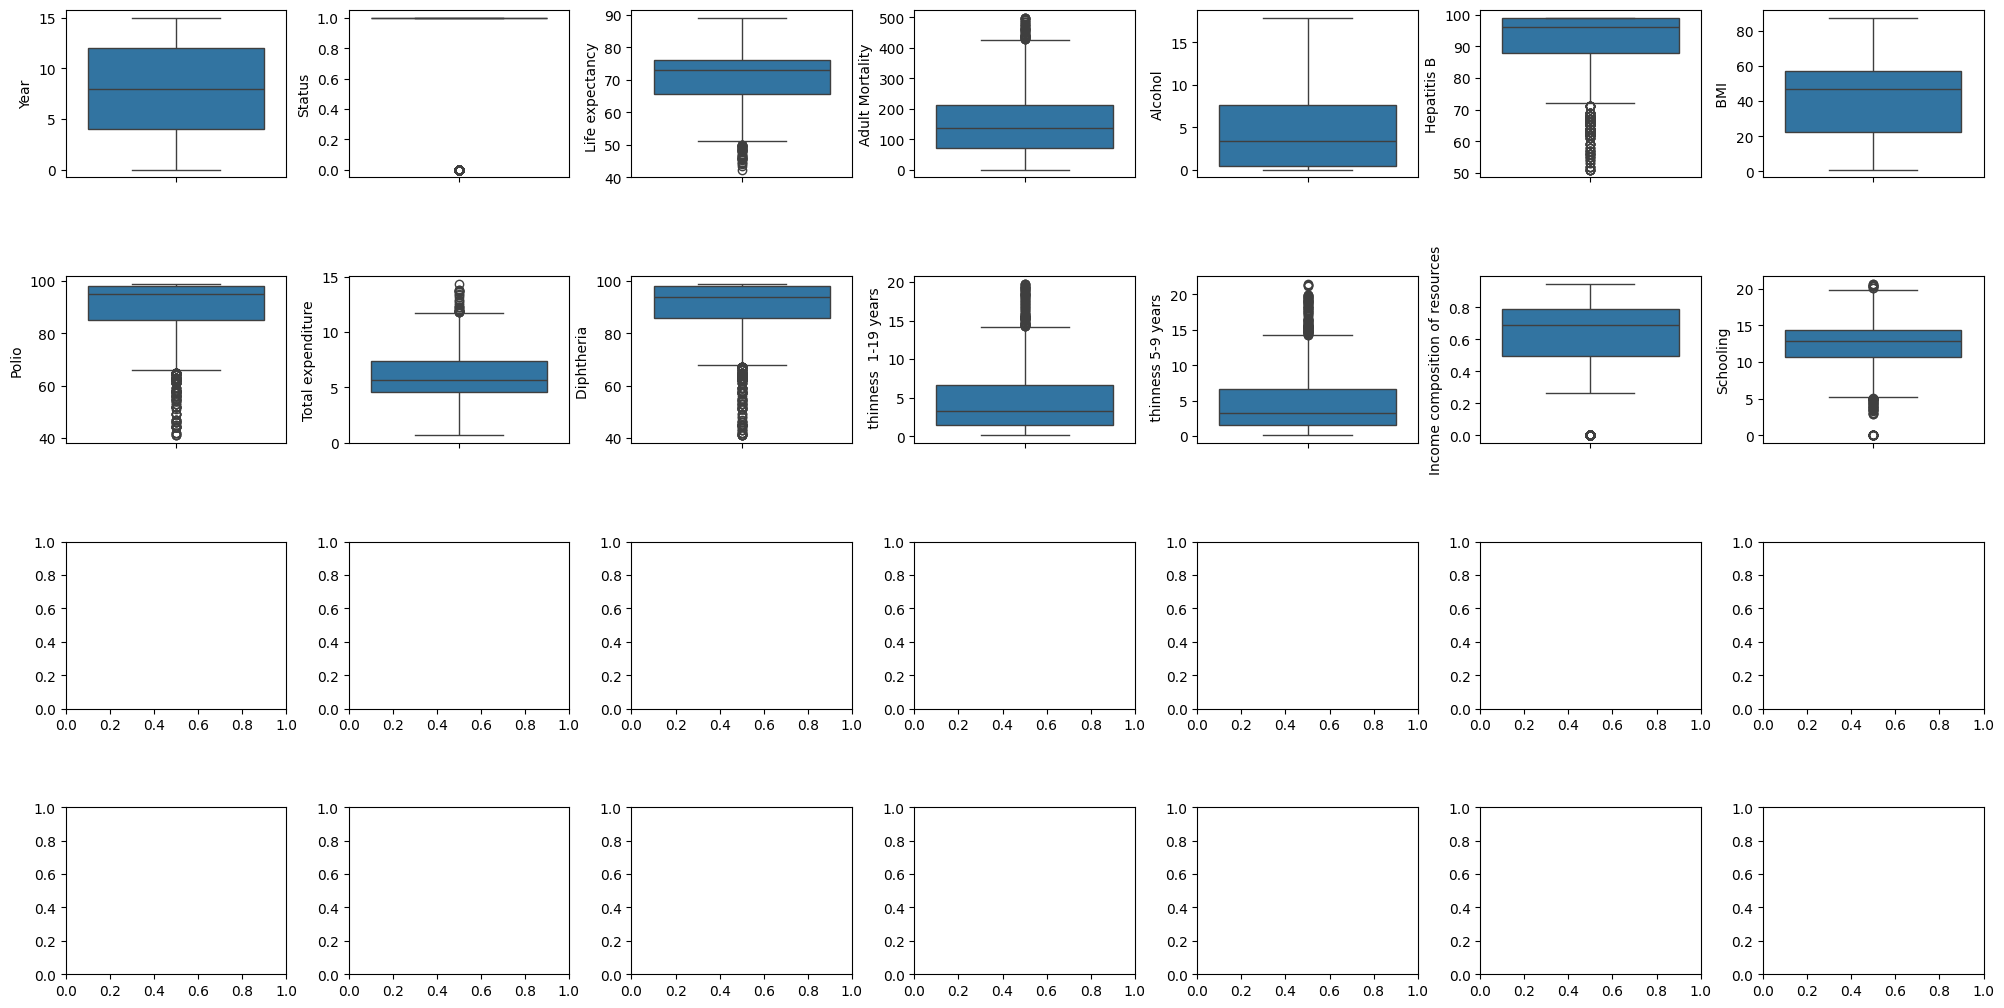

In [15]:
anlyzr = DataAnalyzer()
anlyzr.show_boxplots()
# display(anlyzr.dataset)

In [28]:
wrapper_mstr = Master()
wrapper_mstr.run_with_wrapper()
wrapper_mstr.organize_results()

[-61.60762453510653, -66.8827661163079, -53.64332765130171, -78.2670010607764, -59.17090407530241]


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
drop = [" HIV/AIDS", "infant deaths", "percentage expenditure", "Measles ", "under-five deaths ", "GDP", "Population"]

In [12]:
display(anlyzr.dataset)

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2,14.0,1,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
3,13.0,1,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.47,9.9
4,12.0,1,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,...,67.0,8.52,67.0,0.1,669.959,3696958.0,17.9,18.0,0.463,9.8
5,11.0,1,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
6,10.0,1,58.8,279.0,74.0,0.01,79.679367,66.0,1989.0,16.7,...,66.0,9.2,66.0,0.1,553.32894,2883167.0,18.4,18.4,0.448,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,13.0,1,58.0,399.0,25.0,6.39,10.666707,95.0,0.0,3.8,...,95.0,6.88,95.0,6.8,111.227396,155456.0,6.2,6.0,0.488,10.4
2926,12.0,1,56.6,429.0,26.0,6.09,92.602336,97.0,0.0,3.3,...,95.0,6.69,95.0,8.8,955.648466,1471826.0,6.5,6.4,0.464,9.8
2927,11.0,1,54.9,464.0,28.0,6.0,63.75053,94.0,0.0,29.9,...,93.0,6.31,93.0,13.3,839.927936,14386649.0,6.8,6.7,0.452,10.1
2931,7.0,1,46.6,67.0,29.0,3.88,29.814566,72.0,242.0,28.2,...,73.0,4.47,73.0,23.7,396.998217,1332999.0,8.2,8.2,0.414,9.6


In [13]:
anlyzr.dataset.drop(columns=["infant deaths"])

,Year,Status,Life expectancy,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2,14.0,1,59.9,271.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
3,13.0,1,59.9,268.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.47,9.9
4,12.0,1,59.5,272.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959,3696958.0,17.9,18.0,0.463,9.8
5,11.0,1,59.2,275.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
6,10.0,1,58.8,279.0,0.01,79.679367,66.0,1989.0,16.7,102.0,66.0,9.2,66.0,0.1,553.32894,2883167.0,18.4,18.4,0.448,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,13.0,1,58.0,399.0,6.39,10.666707,95.0,0.0,3.8,36.0,95.0,6.88,95.0,6.8,111.227396,155456.0,6.2,6.0,0.488,10.4
2926,12.0,1,56.6,429.0,6.09,92.602336,97.0,0.0,3.3,39.0,95.0,6.69,95.0,8.8,955.648466,1471826.0,6.5,6.4,0.464,9.8
2927,11.0,1,54.9,464.0,6.0,63.75053,94.0,0.0,29.9,42.0,93.0,6.31,93.0,13.3,839.927936,14386649.0,6.8,6.7,0.452,10.1
2931,7.0,1,46.6,67.0,3.88,29.814566,72.0,242.0,28.2,46.0,73.0,4.47,73.0,23.7,396.998217,1332999.0,8.2,8.2,0.414,9.6


In [23]:
anlyzr.dataset.columns
"Life expectancy" < 42
"Adult Mortality" > 500
"Hepatitis B" < 50
"Polio" < 40
"Total expenditure" > 15,
"Diphtheria" < 40
" thinness  1-19 years" > 20

Index(['Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object', name=0)